In [14]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/monthly_champagne_sales.csv


# [A Template Time series Project](https://machinelearningmastery.com/time-series-forecast-study-python-monthly-sales-french-champagne/)
This will provide a template for working through a time series prediction problem that you can use on your own dataset.
The steps of this project that we will through are as follows.
1. Environment.
2. Problem Description.
3. Test Harness.
4. Persistence.
6. Data Analysis.
8. ARIMA Models.
7. Model Validation.

# 1. Environmment

* SciPy
* NumPy
* Matplotlib
* Pandas
* scikit-learn
* statsmodels

Check your installed versions of these libraries.

# 2. Problem Description

The problem is to **predict the number of monthly sales of champagne** for the Perrin Freres label.
**The dataset provides the number of monthly sales** of champagne *from January 1964 to September 1972*, or just under 10 years of data. The values are *a count of millions of sales and there are 105 observations*.

# 3. Test Harness
We must develop a test harness to investigate the data and evaluate candidate models.
This involves two steps:
* Defining a Validation Dataset.
* Developing a Method for Model Evaluation.

## 3.1 Validation Dataset
The dataset is not current. This means that we cannot easily collect updated data to validate the model.
Therefore we will pretend that it is September 1971 and withhold the last one year of data from analysis and model selection.
This final year of data will be used to validate the final model

## 3.2. Model Evaluation
Model evaluation will only be performed on the data in dataset.csv prepared in the previous section. Model evaluation involves two elements:
* Performance Measure.
* Test Strategy.

### 3.2.1 Performance Measure
The observations are a count of champagne sales in millions of units.
We will evaluate the performance of predictions using the **root mean squared error (RMSE)**. This will give more weight to predictions that are grossly wrong and will have the same units as the original data.

**Any transforms to the data must be reversed before the RMSE is calculated and reported to make the performance between different methods directly comparable.**

We can calculate the RMSE using the helper function from the scikit-learn library mean_squared_error() that calculates the mean squared error(MSE) between a list of expected values (the test set) and the list of predictions. *We can then take the square root of this value to give us an **RMSE score**.*

### 3.2.2 Test Strategy
Candidate models **will be evaluated using walk-forward validation**.
This is because a **rolling-forecast type model is required from the problem definition**. This is where **one-step forecasts** are needed given all available data.

The **walk-forward validation will work as follows**:
* The first 50% of the dataset will be held back to train the model.
* The remaining 50% of the dataset will be iterated and test the model.
* For each step in the test dataset:
    * A model will be trained.
    * A one-step prediction made and the prediction stored for later evaluation.
    * The actual observation from the test dataset will be added to the training dataset for the next iteration.
* The predictions made during the iteration of the test dataset will be evaluated and an RMSE score reported.

Given the *small size of the data*, we will allow a model to be *re-trained given all available data* prior to *each prediction*.

We can write the code for the test harness using simple NumPy and Python code.
Firstly, we can split the dataset into **train and test sets** directly. We’re careful to **always convert a loaded dataset to float32** in case the loaded data still has some String or Integer data types.

Next, we can iterate over the time steps in the test dataset. The train dataset is stored in a Python list as we need to easily append a new observation each iteration and NumPy array concatenation feels like overkill.

The prediction made by the model is called yhat for convention, as the outcome or observation is referred to as y and yhat (a ‘y‘ with a mark above) is the mathematical notation for the prediction of the y variable.

The prediction and observation are printed each observation for a sanity check prediction in case there are issues with the model.

# 4. Persistence
The first step before getting bogged down in data analysis and modeling is to establish a baseline of performance.

This will provide both a template for evaluating models using the proposed test harness and a performance measure by which all more elaborate predictive models can be compared.

The baseline prediction for time series forecasting is called the naive forecast, or persistence.
This is where the observation from the previous time step is used as the prediction for the observation at the next time step.

# 5. Data Analysis
We can use summary statistics and plots of the data to quickly learn more about the structure of the prediction problem.
1. Summary Statistics.
2. Line Plot.
3. Seasonal Line Plots
4. Density Plots.
5. Box and Whisker Plot.

## 5.1 Summary Statistics
Summary statistics provide a quick look at the limits of observed values. It can help to get a quick idea of what we are working with. 
use: series.describe()

Some observations from these statistics include:
* The number of observations (count) matches our expectation, meaning we are handling the data correctly.
* The mean is about 4,641, which we might consider our level in this series.
* The standard deviation (average spread from the mean) is relatively large at 2,486 sales.
* The percentiles along with the standard deviation do suggest a large spread to the data.

## 5.2 Line Plot
A line plot of a time series can provide a lot of insight into the problem. 
series.plot()

Some observations from the plot include:
* There may be an **increasing trend** of sales over time.
* There appears to be **systematic seasonality** to the sales for each year.
* The **seasonal signal appears to be growing** over time, suggesting a **multiplicative relationship** (increasing change).
* There do not appear to be any obvious **outliers**.
* The *seasonality* suggests that the series is almost certainly **non-stationary**

There may be benefit in **explicitly modeling the seasonal component and removing it**. You may also explore using **differencing with one or two** levels in order to make the series *stationary*.

The *increasing trend or* **growth in the seasonal component** may suggest the use of a **log or other power transform**.


## 5.3 Seasonal Line Plots
We can confirm the assumption that the seasonality is a yearly cycle by eyeballing line plots of the dataset by year.
take the 7 full years of data as separate groups and create one line plot for each.
The line plots are aligned vertically to help **spot any year-to-year pattern** (It might have been easier if all season line plots were added to the one graph to help contrast the data for each year.)

We can clearly see a dip each August and a rise from each August to December. This pattern appears the same each year, although at different levels. This will help with any explicitly season-based modeling later.

## 5.4 Density Plot
create a histogram and density plot of the observations without any temporal structure.

Some observations from the plots include:
* The distribution is not Gaussian.
* The shape has a long right tail and may suggest an **exponential distribution**

This lends more support to exploring some power transforms of the data prior to modeling.

## 5.5 Box and Whisker Plots
We can group the *monthly data by year* and get an idea of the **spread of observations for each year** and *how this may be changing*.

We do expect to see some trend (increasing mean or median), but it may be interesting to see how the rest of the distribution may be changing.
The example below groups the observaThe last year (1971) only contains 9 months and may not be a useful comparison with the 12 months of observations for other years. Therefore, only data between 1964 and 1970 was plotted.
Running the example creates 7 box and whisker plots side-by-side, one for each of the 7 years of selected data.

Some observations from reviewing the plots include:
* The median values for each year (red line) may show an increasing trend.
* The spread or middle 50% of the data (blue boxes) does appear reasonably stable.
* There are outliers each year (black crosses); these may be the tops or bottoms of the seasonal cycle.
* The last year, 1970, does look different from the trend in prior years

The observations suggest perhaps some *growth trend over the years* and outliers that may be a part of the seasonal cycle.
This yearly view of the data is an interesting avenue and *could be pursued further by looking at summary statistics* from year-to-year and changes in summary stats from year-to-year.

# 6. ARIMA Models

## 6.1 Manually Configured ARIMA


### 6.1.1 Choosing d
Analysis of the time series data assumes that we are working with a stationary time series.
**The time series is almost certainly non-stationary**. We can *make it stationary this by first **differencing** the series and using a statistical test* to confirm that the result is stationary.

The seasonality in the series is seemingly year-to-year. **Seasonal data can be differenced by subtracting the observation from the same time in the previous cycle**, in this case the same month in the previous year. This does mean that we will lose the first year of observations as there is no prior year to difference with.

**Doing the proc on the example:**
The results show that the test statistic value -7.134898 is smaller than the critical value at 1% of -3.515. This suggests that we can reject the null hypothesis with a significance level of less than 1% (i.e. a low probability that the result is a statistical fluke).
Rejecting the null hypothesis means that the process has no unit root, and in turn that the time series is stationary or does not have time-dependent structure.


For reference, **the seasonal difference operation can be inverted by adding the observation for the same month the year before**. This is needed **in the case that predictions are made by a model fit on seasonally differenced data**. The function to invert the seasonal difference operation is listed below for completeness.

A plot of the differenced dataset is also created.
The plot does not show any obvious seasonality or trend, suggesting the seasonally differenced dataset is a good starting point for modeling.
**We will use this dataset as an input to the ARIMA model**. It also suggests that no further differencing may be required, and that the **d parameter may be set to 0**.

### 6.1.2 Choosing p and q
The next first step is to select the lag values for the Autoregression (AR) and Moving Average (MA) parameters, p and q respectively.
**We can do this by reviewing Autocorrelation Function (ACF) and Partial Autocorrelation Function (PACF) plots.** 

*Note, we are now using the seasonally differenced stationary.csv as our dataset*

Run the example and review the plots for insights into how to set the p and q variables for the ARIMA model. Below are some observations from the plots.
* The ACF shows a significant lag for 1 month.
* The PACF shows a significant lag for 1 month, with perhaps some significant lag at 12 and 13 months.
* Both the ACF and PACF show a drop-off at the same point, perhaps suggesting a mix of AR and MA.
A good starting point for the p and q values is also 1.
The PACF plot also suggests that there is still some seasonality present in the differenced data. We may consider a better model of seasonality, such as modeling it directly and explicitly removing it from the model rather than seasonal differencing.

**This quick analysis suggests an ARIMA(1,0,1) on the stationary data may be a good starting point.**
Experimentation shows that this configuration of ARIMA does not converge and results in errors by the underlying library. Further experimentation showed that adding one level of differencing to the stationary data made the model more stable. The model can be extended to **ARIMA(1,1,1)**.

We will also **disable the automatic addition of a trend constant from the model by setting the ‘trend‘ argument to ‘nc‘ for no constant in the call to fit().** From experimentation, I find that this can result in better forecast performance on some problems.
The example below demonstrates the performance of this ARIMA model on the test harness.



## 6.3 Review Residual Errore
A good final check of a model is to review residual forecast errors.
**Ideally, the distribution of residual errors should be a Gaussian with a zero mean.** 
We can check this by using **summary statistics** and **plots** to investigate the residual errors from the ARIMA(0, 0, 1) model. 



Series length=105
5 first lines of data:
 Month
1964-01-01    2815
1964-02-01    2672
1964-03-01    2755
1964-04-01    2721
1964-05-01    2946
Name: Sales, dtype: int64
Dataset 93, Validation 12
Train 46, Test 47
Predicted: 6793.247
<class 'pandas.core.series.Series'>
12 12 93 93 94
RMSE: 372.581
<class 'pandas.core.series.Series'>


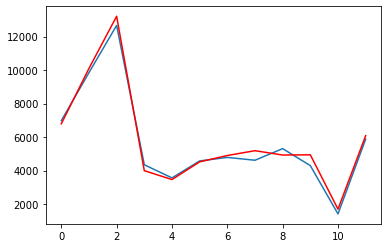

In [13]:
#STEP1: ENV
import matplotlib.pyplot as plt

import numpy as np;  #print('numpy: %s' % np.__version__)
import pandas as pd; #print('pandas: %s' % pd.__version__)
from pandas import Series
from pandas.plotting import lag_plot, autocorrelation_plot

import matplotlib ; #print('matplotlib: %s' % matplotlib.__version__)
import matplotlib.pyplot as plt
import statsmodels; #print('statsmodels: %s' % statsmodels.__version__)
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.arima_model import ARIMAResults
from statsmodels.tsa.stattools import adfuller

import sklearn; #print('sklearn: %s' % sklearn.__version__)
from sklearn.metrics import mean_squared_error
import scipy as sp; #print('scipy: %s' % sp.__version__)

from math import sqrt
import warnings 
warnings.filterwarnings("ignore")


#STEP2: Problem
def load_data(path):
    #from pandas import read_csv
    series = pd.read_csv(path, header=0, parse_dates=True, index_col=0, squeeze=True)
    print('Series length=%d' % len(series))
    print ('5 first lines of data:\n', series.head(5))
    return series


# STEP3: Test Harness
# 3.1 Validation Dataset: separate out a validation dataset
def split_set(series, split_percentage, filename1, filename2):
    split_point = int(len(series) * split_percentage)
    set1, set2 = series[0:split_point], series[split_point:]
    set1.to_csv(filename1 , header=False)
    set2.to_csv(filename2, header=False)
    return set1, set2

def prepare_data(series):
    return series.values.astype('float32')

# 3.2 Model Evaluation
# 3.2.1 Perf Measur
def model_evaluation_perf_measure(test, predictions):
    mse = mean_squared_error(test, predictions)
    rmse = sqrt(mse)
    print('RMSE: %.3f' % rmse)
    
    mape = np.mean(np.abs(predictions - test)/np.abs(test))  
    print('Mean Absolute Percentage Error (MAPE): %.3f' % mape)
    
    corr = np.corrcoef(predictions, test)[0,1]   # corr
    
    mins = np.amin(np.hstack([predictions[:,None], test[:,None]]), axis=1)
    maxs = np.amax(np.hstack([predictions[:,None],test[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    
    return rmse

# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    acf1 = acf(fc-test)[1]                      # ACF1
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse, 'acf1':acf1, 
            'corr':corr, 'minmax':minmax})

#forecast_accuracy(fc, test.values)

# 3.2.2 Test Strategy
def model_evaluation(train, test, predict_model='baseline', order=(1,0,0), 
                     stationary=False, interval=1, bias=0):
    # walk-forward validation
    history = [x for x in train]
    predictions = list()
    for i in range(len(test)):
        if predict_model == 'baseline':
            yhat = baseline_predict(history)
            #yhat = history[-1]
        elif predict_model == 'ARIMA' or predict_model=='arima' or predict_model == 'Arima':
            if stationary : 
                yhat = arima_predict(history, order, stationary, interval, bias)
            else:
                yhat = arima_predict(history, order)
        predictions.append(yhat)
        obs = test[i]                   # observation
        history.append(obs)  
        #print('>Predicted=%.3f, Expected=%3.f' % (yhat, obs))

    # report performance
    rmse = model_evaluation_perf_measure(test, predictions)
    return rmse, predictions 


# Persistence-Baseline:
def baseline_predict(history):
    yhat = history[-1]
    return yhat

# ARIMA:
# create a differenced series
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return np.array(diff) 

# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]

def arima_predict(history, arima_order, stationary=False, interval=1, bias=0):    
    if stationary :
        model = ARIMA(difference(history, interval), arima_order)
        model_fit = model.fit(trend='nc', disp=0)
        output = model_fit.forecast()
        yhat = output[0] 
        yhat = bias + inverse_difference(history, yhat, interval)
    else:
        model = ARIMA(history, arima_order)
        model_fit = model.fit(disp=0)
        output = model_fit.forecast()
        yhat = bias + output[0]
    return yhat

def arima_fitted_predict(dataset, model, bias, stationary=False, interval=1):    
    model_fit = ARIMAResults.load(model)
    bias = np.load(bias)
    output = float(model_fit.forecast()[0])
    if stationary :
        yhat = bias + inverse_difference(dataset, output, interval)
    else:
        yhat = bias + output
    print('Predicted: %.3f' % yhat)
    return yhat

def check_stattionary(data, epsilon=0.05):
    result = adfuller(data)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
        
    if result[1] < epsilon :
        print('data is stationary')
        return True
    else:
        print('data is NOT stationary')
        return False
    
def make_stationary(train,difference_intervals, stattionary_filename='stationary.csv'):
    stationary = Series(difference(train, difference_intervals))
    stationary.index = Series(train).index[difference_intervals:]
    # check if stationary
    result = check_stationary(stationary)
    if result :
        stationary.to_csv(stattionary_filename, header=False)
    else:
        print('It is still Not stationary. pls add more intervals!')
    stationary.plot()
    plt.show()

def hyperparam_tuning(train, test, p_values, d_values, q_values,
                          stationary=False, interval=1):
    best_score, best_cfg, best_predictions = float("inf"), None, list()
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order=(p,d,q)
                try:
                    if stationary: 
                        rmse, predictions = model_evaluation(train, test, 
                                                             predict_model='ARIMA', 
                                                             order=order, 
                                                             stationary=stationary, 
                                                             interval=interval)
                        
                    else:
                        rmse, predictions = model_evaluation(train, test,
                                                             predict_model='ARIMA', 
                                                             order=order)
                        


                    print('Arima Order(%d,%d,%d) RMSE: %.3f' % (p,d,q,rmse))
                    if rmse < best_score:
                        best_score, best_cfg, best_predictions = rmse, order, predictions
                except:
                    continue
    print ('Best ARIMA%s Rms=%.3f' % (best_cfg, best_score))
    return best_score, best_cfg, best_predictions

# monkey patch around bug in ARIMA class
def __getnewargs__(self):
    return ((self.endog),(self.k_lags, self.k_diff, self.k_ma))
               
def finalize_model(data, interval=1,arima_order=(1,0,0), bias=0, 
                   model_filename='model.pkl', model_bias_filename='model_bias.npy'):
    from scipy.stats import boxcox
    ARIMA.__getnewargs__ = __getnewargs__
    
    diff = difference(data, interval)
    # fit model
    model = ARIMA(diff, order=arima_order)
    model_fit = model.fit(trend='nc', disp=0)
    
    # Actual vs Fitted
    print(model_fit.summary())
    model_fit.plot_predict(dynamic=False)
    plt.show()
    model.plot_diagnostics(figsize=(7,5))
    plt.show()

    # save model
    model_fit.save(model_filename)
    np.save(model_bias_filename, [bias])
    return

def validate_model(data, validation,
                   predict_model='ARIMA',order=(0,0,1), stationary=True, interval=1,
                   model='model.pkl', bias='model_bias.npy'):
    X = data 
    y = validation
    yhat = arima_fitted_predict(data, model, bias, stationary, interval)
    final_predictions = list()
    final_predictions.append(yhat)
    #print('>Predicted=%.3f, Expected=%3.f' % (yhat, y[0]))

    history = [x for x in X]
    history.append(y[0])
    print (type(y))
    print (len(y), len(validation), len(X), len(data), len(history))
    y_temp = y[1:]
    rmse, predictions = model_evaluation(history, y_temp, predict_model,order, stationary,
                                         interval,np.load('model_bias.npy'))

    final_predictions.extend(predictions)
    print (type(y))
    plt.plot(y.values)
    plt.plot(final_predictions, color='red')
    plt.show()
    

# STEP 5: Data Analysis Plots
def data_analysis_plot_simple(series):
    #5.1: summary Statics
    print ('5.1: Series Description is:\n', series.describe())
    
    #5.2: Line Plot
    import matplotlib.pyplot as plt 
    series.plot(style='k-')
    plt.show()
    series.plot(style='k.')
    plt.show()
    
    #5.4: Density Plot  
    plt.figure(1)
    plt.subplot(211)
    series.hist()
    plt.subplot(212)
    series.plot(kind='kde')
    plt.show()
       
def data_analysis_plot_seasonal_box(series, start, end, freq='A'):
    #5.3: Seasonal Line Plot     
    groups = series[start:end].groupby(pd.Grouper(freq=freq))
    years = pd.DataFrame()    
    for name, group in groups:
        years[name.year] = group.values
    #years.plot(subplots=True, legend = False)
    years.plot()
    plt.show()

    #5.5:  Box & Wishker Plot   
    years.boxplot()
    plt.show()

def data_analysis_plot_lag_correlation(series, lag=1):
    lag_plot(series, lag)
    plt.show() 

    # Pearson Correlation Coefficients
    autocorrelation_plot(series)
    plt.show()
    
    #plot_acf(series, lags=lag, ax=plt.gca())
    plot_acf(series, ax=plt.gca())
    plt.show()
    
    #plot_pacf(series, lags=lag, ax=plt.gca())
    plot_pacf(series, ax=plt.gca())
    plt.show()

def plot_sets_results(train, test, predictions):
    plt.plot(test)
    plt.plot(predictions, color='red')
    plt.show()

    plt.plot(train)
    plt.plot([None for i in train] + [x for x in test])
    plt.plot([None for i in train] + [x for x in predictions])
    plt.show()
    
    
def plot_Residuals( test, predictions):
    residuals = [test[i]-predictions[i] for i in range(len(test))]
    residuals = pd.DataFrame(residuals)
    print(residuals.describe())
    plt.figure()
    plt.subplot(221)
    residuals.hist(ax=plt.gca())
    plt.subplot(222)
    residuals.plot(kind='kde', ax=plt.gca())
    plt.subplot(223)
    plot_acf(residuals, ax=plt.gca())
    plt.subplot(224)
    plot_pacf(residuals, ax=plt.gca())
    plt.show()
    
# Step1: Load And Analyse data     
path = "/kaggle/input/champagneproject/monthly_champagne_sales.csv"
series = load_data(path)
#data_analysis_plot_simple(series)
#data_analysis_plot_seasonal_box(series,'1964', '1970', freq='A')
#data_analysis_plot_lag_correlation(series,1)

#Step2: Create train, cv, test sets
data, validation = split_set(series, 0.89, 'dataset.csv', 'validation.csv')
print('Dataset %d, Validation %d' % (len(data), len(validation)))
train, test = split_set(data, 0.50, 'train.csv', 'test.csv')
print('Train %d, Test %d' % (len(train), len(test)))
train = prepare_data(train)
test = prepare_data(test)
    
#Step3: Baseline/Naive
#rmse, predictions  = model_evaluation(train, test, predict_model='baseline')
#plot_sets_results(train, test, predictions)

#Step5: First Arima
#rmse, predictions = model_evaluation(train, test, predict_model='ARIMA', order=(1,0,0))
#plot_sets_results(train, test, predictions)

#Step6: Arima using Manual config based on plots
months_in_year = 12
#make_stationary(train,difference_intervals=months_in_year)
#rmse, predictions = model_evaluation(train, test, predict_model='ARIMA', order=(0,0,1), 
#                 stationary=True, interval=months_in_year)
#plot_sets_results(train, test, predictions)

#Step7: Hyper-param Tuning
#p_values = range(0,7) #[0,1,2,4,6,8,10]
#d_values = range(0,3)
#q_values = range(0,7)
#best_score, best_cfg, predictions = hyperparam_tuning(train, test, 
#                                                      p_values, d_values, q_values,
#                                                      stationary=True, 
#                                                      interval=months_in_year)
#plot_sets_results(train, test, predictions)

# Find  bias
#rmse, predictions = model_evaluation(train, test, predict_model='ARIMA', order=(0,0,1), 
#                                     stationary=True, interval=months_in_year)
#plot_sets_results(train, test, predictions)
#plot_Residuals(test, predictions)
#bias = 165

#Step7: Finaliz model using best found hyperparam
#! rm /kaggle/working/model*
#finalize_model(data, months_in_year, (0,0,1), bias,'model.pkl','model_bias.npy')
# ! ls /kaggle/working

#Step8: Make prediction
#prdct = arima_fitted_predict(data, 'model.pkl', 'model_bias.npy',True, months_in_year)

#Step9: Validate Model
#validate_model(data, validation, 'ARIMA',(0,0,1), True, months_in_year,
#               'model.pkl','model_bias.npy')

Series length=108
5 first lines of data:
 Month
1960-01-01     6550
1960-02-01     8728
1960-03-01    12026
1960-04-01    14395
1960-05-01    14587
Name: Sales, dtype: int64
Dataset 91, Validation 17
Train 63, Test 28
ADF Statistic: -3.675754
p-value: 0.004467
Critical Values:
	1%: -3.610
	5%: -2.939
	10%: -2.608


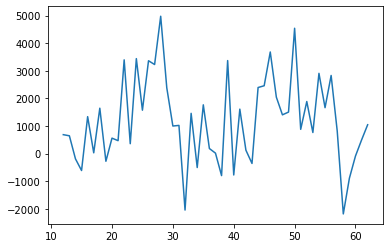

RMSE: 2058.252
Arima Order(0,0,1) RMSE: 2058.252
RMSE: 2149.029
Arima Order(0,0,2) RMSE: 2149.029
RMSE: 2134.707
Arima Order(0,0,3) RMSE: 2134.707
RMSE: 2137.390
Arima Order(0,0,4) RMSE: 2137.390
RMSE: 2092.144
Arima Order(0,0,5) RMSE: 2092.144
RMSE: 2453.001
Arima Order(0,0,6) RMSE: 2453.001
RMSE: 2405.261
Arima Order(0,0,7) RMSE: 2405.261
RMSE: 2412.785
Arima Order(0,0,8) RMSE: 2412.785
RMSE: 2419.045
Arima Order(0,0,9) RMSE: 2419.045
RMSE: 2298.491
Arima Order(0,0,10) RMSE: 2298.491
RMSE: 2299.843
Arima Order(0,0,11) RMSE: 2299.843
RMSE: 2059.262
Arima Order(0,1,1) RMSE: 2059.262
RMSE: 2086.066
Arima Order(0,1,2) RMSE: 2086.066
RMSE: 2070.086
Arima Order(0,1,3) RMSE: 2070.086
RMSE: 2084.003
Arima Order(0,1,4) RMSE: 2084.003
RMSE: 2153.606
Arima Order(0,1,5) RMSE: 2153.606
RMSE: 2459.950
Arima Order(0,1,6) RMSE: 2459.950
RMSE: 2444.425
Arima Order(0,1,7) RMSE: 2444.425
RMSE: 2473.229
Arima Order(0,1,8) RMSE: 2473.229
RMSE: 2442.386
Arima Order(0,1,9) RMSE: 2442.386
RMSE: 2376.659
Ari

In [ ]:
# Step1: Load And Analyse data     
path = "/kaggle/input/carsale/monthly-car-sales.csv"
series = load_data(path) # 1960-1968, monthly
#print(series.tail())
#print (pd.DataFrame(series))

#data_analysis_plot_simple(series) #Trend & Seasonal
#data_analysis_plot_lag_correlation(series,1) #lag=1,13,
#data_analysis_plot_seasonal_box(series,'1960', '1968', freq='A') #Month: 4, 8

#Step2: Create train, cv, test sets
data, validation = split_set(series, 0.85, 'dataset.csv', 'validation.csv')
print('Dataset %d, Validation %d' % (len(data), len(validation)))
train, test = split_set(data, 0.70, 'train.csv', 'test.csv')
print('Train %d, Test %d' % (len(train), len(test)))
train = prepare_data(train)
test = prepare_data(test)
    
#Step3: Baseline/Naive
#rmse, predictions  = model_evaluation(train, test, predict_model='baseline')
#plot_sets_results(train, test, predictions) #Base RMSE:3812

#Step5: First Arima
#rmse, predictions = model_evaluation(train, test, predict_model='ARIMA', order=(12,1,6))
#plot_sets_results(train, test, predictions)

#Step6: Arima using Manual config based on plots
months_in_year = 12
make_stationary(train,difference_intervals=months_in_year)
check_stattionary()
#rmse, predictions = model_evaluation(train, test, predict_model='ARIMA', order=(0,0,1), 
#                 stationary=True, interval=months_in_year)
#plot_sets_results(train, test, predictions)

#Step7: Hyper-param Tuning
p_values = range(0,12) #[0,1,2,4,6,8,10]
d_values = range(0,3)
q_values = range(0,12)
best_score, best_cfg, predictions = hyperparam_tuning(train, test, 
                                                      p_values, d_values, q_values,
                                                      stationary=True, 
                                                      interval=months_in_year)
plot_sets_results(train, test, predictions)

# Find  bias
#rmse, predictions = model_evaluation(train, test, predict_model='ARIMA', order=(0,0,1), 
#                                     stationary=True, interval=months_in_year)
#plot_sets_results(train, test, predictions)
#plot_Residuals(test, predictions)
#bias = 165

#Step7: Finaliz model using best found hyperparam
#! rm /kaggle/working/model*
#finalize_model(data,months_in_year, (0,0,1), bias,'model.pkl','model_bias.npy')
# ! ls /kaggle/working

#Step8: Make prediction
#prdct = arima_fitted_predict(data, 'model.pkl', 'model_bias.npy',True, months_in_year)

#Step9: Validate Model
#validate_model(data, validation, 'ARIMA',(0,0,1), True, months_in_year,
#               'model.pkl','model_bias.npy')

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

df = pd.read_csv('https://raw.githubusercontent.com/selva86/datasets/master/wwwusage.csv', names=['value'], header=0)

model = pm.auto_arima(df.value, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())